In [1]:
from __future__ import print_function, division
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

from torch.optim import lr_scheduler

import torchvision
from torchvision import models, transforms

import pytorch_lightning as pl
from pytorch_lightning.metrics import TensorMetric

from PIL import Image
import os, sys
import argparse
from types import SimpleNamespace
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd

if os.path.abspath('..') not in sys.path:
    sys.path.append(os.path.abspath('..'))
from data_utils import get_class_freq, get_class_weights, get_resampled_data, get_upsampling_counts
from plotting import imshow
import pickle

In [2]:
DATA_DIR = 'data/myntradataset'
RANDOM_SEED=42
pl.seed_everything(RANDOM_SEED)

42

In [3]:
%pdb off

Automatic pdb calling has been turned OFF


## Data feeding

In [4]:
class ImageDFData(Dataset):
    """Loads images based on the path contained in the pd.DataFrame.
       Creates unique integer labels from class names sorted alphabetically
       
       Parameters:
            df: pd.DataFrame - dataframe with paths to data and class names
            transform: callable, optional - A function/transform that takes in an PIL image
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        """ 
            Args:
                index: int
            Returns:
                (sample, label) where target is class_index of the target class.
            Return type:
                tuple
        """
        image = Image.open(self.df.image[index]).convert("RGB")
        label = self.df['class'][index]
        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
class FashionDataModule(pl.LightningDataModule):
    def __init__(self, df_train, df_val, batch_size=1, num_workers=4):
        super().__init__()
        self.df_train = df_train
        self.df_val = df_val
        self.batch_size = batch_size
        self.num_workers = num_workers
                
    def setup(self, stage=None):
            
        # Transforms / Augmentations
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        transform_augment = transforms.Compose([
            #transforms.RandomResizedCrop(224),
            transforms.Resize(256),
            transforms.RandomRotation(5),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=[0.9, 1.1], contrast=[0.9, 1.1]),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        self.val_dataset = ImageDFData(self.df_val, transform=transform)
        self.train_dataset = ImageDFData(self.df_train, transform=transform_augment)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          num_workers=self.num_workers) if self.val_dataset else None
    def test_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          num_workers=self.num_workers) if self.val_dataset else None

In [6]:
def test_dataloaders():
    train_top20_df = pd.read_pickle(os.path.join(DATA_DIR, 'train_top20.p'))
    test_df = pd.read_pickle(os.path.join(DATA_DIR, 'test.p'))
    class_labels = pd.read_pickle(os.path.join(DATA_DIR, 'class_labels.p'))
    
    dm = FashionDataModule(train_top20_df, test_df, batch_size=16)
    dm.setup()
    # Visualize train batch
    inputs, classes = next(iter(dm.train_dataloader()))
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_labels[x.numpy()] for x in classes])
    
    # Visualize val batch
    inputs, classes = next(iter(dm.val_dataloader()))
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_labels[x.numpy()] for x in classes])

In [7]:
#test_dataloaders()

## Training setup

In [8]:
### Define training pipeline

In [9]:
def topk_accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = torch.topk(output, maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(1.0 / batch_size))
    return res


In [10]:
class FocalLoss(nn.Module):
    """
    Taken from: https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
    """
    def __init__(self, alpha=1.0, gamma=2.0, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        num_classes = inputs.shape[1]
        targets_vec = nn.functional.one_hot(targets, num_classes).type_as(inputs)

        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets_vec, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets_vec, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [11]:
class LitModel(pl.LightningModule):

    def __init__(self, criterion, learning_rate=1e-3):
        super().__init__()
        ### Define the model
        num_classes = 142
        model = models.resnet18(pretrained=True)
        num_hidden = model.fc.in_features
        # Replace last layer
        model.fc = nn.Linear(num_hidden, num_classes)

        self.model = model
        self.criterion = criterion
        self.lr = learning_rate
        self.example_input_array = torch.rand(1, 3, 224, 224)

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        lr = self.lr if self.lr else 1e-3
        optimizer = torch.optim.Adam(self.parameters(), lr)
        #scheduler = torch.optim.lr_scheduler.OneCycleLR(
        #    optimizer, max_lr=lr * 30, total_steps=10)
        scheduler = {
             'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(
             optimizer, mode='min', factor=0.1, patience=3, threshold=0.0001,
             min_lr=1e-6, threshold_mode='rel', verbose=True),
             'monitor': 'checkpoint_on', # This is loss
             'interval': 'epoch',
             'frequency': 1
          }
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        
        result = pl.TrainResult(minimize=loss, checkpoint_on=loss)
        result.log('train_loss', loss, on_epoch=True)
        return result

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        top1_acc, top5_acc = topk_accuracy(y_hat, y, topk=(1, 5))
        
        result = pl.EvalResult(checkpoint_on=(1 - top1_acc))
        result.log('val_loss', loss, prog_bar=True)
        result.log_dict({'val_top1_acc': top1_acc, 'val_top5_acc': top5_acc})
        return result

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        top1_acc, top5_acc = topk_accuracy(y_hat, y, topk=(1, 5))
        
        result = pl.EvalResult()
        result.log('top1_acc', top1_acc)
        result.log('top5_acc', top5_acc)
        return result

In [12]:
def plot_training_data(log_file):
    data = pd.read_csv(log_file)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    for ax in axes:
        ax.set_xlabel('epoch')
    for field in ['val_loss', 'epoch_train_loss']:
        axes[0].plot(data[['epoch', field]].dropna().set_index('epoch'), label=field)
    axes[0].set_ylabel('loss')
    axes[0].legend(loc='upper right')
    
    for field in ['val_top1_acc', 'val_top5_acc']:
        axes[1].plot(data[['epoch', field]].dropna().set_index('epoch'), label=field)
    axes[1].set_ylabel('accuracy')
    axes[1].legend(loc='upper right')

## Training 

In [13]:
def train(dm, exp_version, criterion=nn.CrossEntropyLoss(), max_epochs=10):
    ### set up logging / checkpointing locations 
    #try:
    #    run_id = os.environ['SLURM_JOB_ID']
    #except:
    run_id = str(os.getpid())
    base_dir = os.path.join(os.getcwd(), 'lightning_logs')
    checkpoint_dir = os.path.join(base_dir, run_id, 'checkpoints')
    train_log_file = os.path.join(base_dir, run_id, exp_version, 'metrics.csv')
    hparams_file = os.path.join(base_dir, run_id, exp_version, 'hparams.yaml')
    
    results = {'run_id': run_id, 'checkpoint_dir': checkpoint_dir,
               'train_log_file': train_log_file, 'hparams_file': hparams_file}

    log_tb = pl.loggers.TensorBoardLogger(base_dir, name=run_id,
                                          version=exp_version+'_tb')
    log_csv = pl.loggers.CSVLogger(base_dir, name=run_id,
                                   version=exp_version)

    checkpoint_cb = pl.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, '{epoch}-{val_loss:.2f}'), verbose=True)

    lr_logger_cb = pl.callbacks.LearningRateLogger(logging_interval='epoch')

    ## instantiate data module / model / trainer
    lm = LitModel(criterion)

    trainer = pl.Trainer(gpus=1, deterministic=True, max_epochs=max_epochs,
                         #auto_lr_find=True,
                         logger = [log_tb, log_csv],
                         checkpoint_callback=checkpoint_cb,
                         callbacks=[lr_logger_cb],
                         limit_val_batches=1.0,
                         )
    # run lr finder
    lr_finder = trainer.lr_find(lm, dm)
    lm.lr = lr_finder.suggestion()
    # fit model
    trainer.fit(lm, dm)
        
    results['best_model_path'] = checkpoint_cb.best_model_path
    return results

In [14]:
### testing
def test(dm, best_model_path, criterion=nn.CrossEntropyLoss()):
    #loading best weights and testing
    checkpoint = torch.load(best_model_path)
    lm = LitModel(criterion)
    lm.load_state_dict(checkpoint['state_dict'])
    
    trainer = pl.Trainer(resume_from_checkpoint=best_model_path, gpus=1)
    results = trainer.test(lm, dm.test_dataloader())
    
    return results

In [15]:
def plot_top_for_each_class(class_labels, data, best_model_path, criterion=nn.CrossEntropyLoss()):
    """Calculates and plots top1 and top5 accuracies for classes provided in class_labels"""

    #loading best weights and testing
    checkpoint = torch.load(best_model_path)
    lm = LitModel(criterion)
    lm.load_state_dict(checkpoint['state_dict'])

    result = class_labels.to_frame(name='label')
    result['top1_acc'] = np.nan
    result['top5_acc'] = np.nan

    for elem in result.index:
        data_part = data.where(data['class']==elem).dropna().reset_index(drop=True)
        dm = FashionDataModule(data_part, data_part, batch_size=384)
        dm.setup()
        trainer = pl.Trainer(resume_from_checkpoint=best_model_path, gpus=1)
        res = trainer.test(lm, dm.test_dataloader())
        result.loc[elem, 'top1_acc'] = res[0]['top1_acc']
        result.loc[elem, 'top5_acc'] = res[0]['top1_acc']

    axes = result.set_index('label').plot.barh(rot=0, subplots=True, figsize=(10, 8))
    axes[1].legend(loc=2)
    return result.to_dict()

## Experiments

### Top-20 classes

In [16]:
batch_size = 384
class_labels = pd.read_pickle(os.path.join(DATA_DIR, 'class_labels.p'))
results_balancing_methods = {}

#### Train as is without class balancing

In [17]:
### Load dataset index files
train_df = pd.read_pickle(os.path.join(DATA_DIR, 'train_top20.p'))
val_df = pd.read_pickle(os.path.join(DATA_DIR, 'test.p'))
dm = FashionDataModule(train_df, val_df, batch_size)

In [18]:
res_tr = train(dm, 'initial', max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name      | Type             | Params | In sizes         | Out sizes
------------------------------------------------------------------------------
0 | model     | ResNet           | 11 M   | [1, 3, 224, 224] | [1, 142] 
1 | criterion | CrossEntropyLoss | 0      | ?                | ?        
Finding best initial lr: 100%|██████████| 100/100 [03:48<00:00,  3.04s/it]Saving latest checkpoint..
Set SLURM handle signals.

  | Name      | Type             | Params | In sizes         | Out sizes
------------------------------------------------------------------------------
0 | model     | ResNet           | 11 M   | [1, 3, 224, 224] | [1, 142] 
1 | criterion | CrossEntropyLoss | 0      | ?                | ?        


Epoch 1:  47%|████▋     | 47/101 [00:54<01:02,  1.16s/it, loss=0.248, v_num=tial, val_loss=1.66e+8]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 101/101 [01:29<00:00,  1.13it/s, loss=0.248, v_num=tial, val_loss=1.66e+8]


Epoch 00001: val_checkpoint_on reached 0.38549 (best 0.38549), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=1-val_loss=3.34.ckpt as top 1


Epoch 2:  47%|████▋     | 47/101 [00:54<01:02,  1.17s/it, loss=0.151, v_num=tial, val_loss=3.34] 
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 101/101 [01:29<00:00,  1.12it/s, loss=0.151, v_num=tial, val_loss=3.34]


Epoch 00002: val_checkpoint_on  was not in top 1


Epoch 3:  47%|████▋     | 47/101 [00:55<01:03,  1.17s/it, loss=0.114, v_num=tial, val_loss=3.35] 
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 101/101 [01:30<00:00,  1.12it/s, loss=0.114, v_num=tial, val_loss=3.35]


Epoch 00003: val_checkpoint_on reached 0.37277 (best 0.37277), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=3-val_loss=3.26.ckpt as top 1


Epoch 4:  47%|████▋     | 47/101 [00:54<01:03,  1.17s/it, loss=0.094, v_num=tial, val_loss=3.26] 
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 101/101 [01:29<00:00,  1.12it/s, loss=0.094, v_num=tial, val_loss=3.26]


Epoch 00004: val_checkpoint_on  was not in top 1


Epoch 5:  47%|████▋     | 47/101 [00:54<01:02,  1.16s/it, loss=0.072, v_num=tial, val_loss=3.25] 
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 101/101 [01:29<00:00,  1.13it/s, loss=0.072, v_num=tial, val_loss=3.25]


Epoch 00005: val_checkpoint_on  was not in top 1


Epoch 6:  47%|████▋     | 47/101 [00:55<01:03,  1.17s/it, loss=0.066, v_num=tial, val_loss=3.46] 
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 101/101 [01:30<00:00,  1.12it/s, loss=0.066, v_num=tial, val_loss=3.46]


Epoch 00006: val_checkpoint_on reached 0.36664 (best 0.36664), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=6-val_loss=3.30.ckpt as top 1


Epoch 7:  47%|████▋     | 47/101 [00:54<01:02,  1.16s/it, loss=0.063, v_num=tial, val_loss=3.3] 
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 101/101 [01:29<00:00,  1.13it/s, loss=0.063, v_num=tial, val_loss=3.3]


Epoch 00007: val_checkpoint_on  was not in top 1


Epoch 8:  47%|████▋     | 47/101 [00:54<01:02,  1.16s/it, loss=0.058, v_num=tial, val_loss=3.57] 
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 101/101 [01:29<00:00,  1.13it/s, loss=0.058, v_num=tial, val_loss=3.57]


Epoch 00008: val_checkpoint_on  was not in top 1


Epoch 9:  47%|████▋     | 47/101 [00:54<01:02,  1.16s/it, loss=0.049, v_num=tial, val_loss=3.92] 
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 101/101 [01:30<00:00,  1.12it/s, loss=0.049, v_num=tial, val_loss=3.92]


Epoch 00009: val_checkpoint_on  was not in top 1


Epoch 9: 100%|██████████| 101/101 [01:30<00:00,  1.12it/s, loss=0.049, v_num=tial, val_loss=3.85]
                                                           

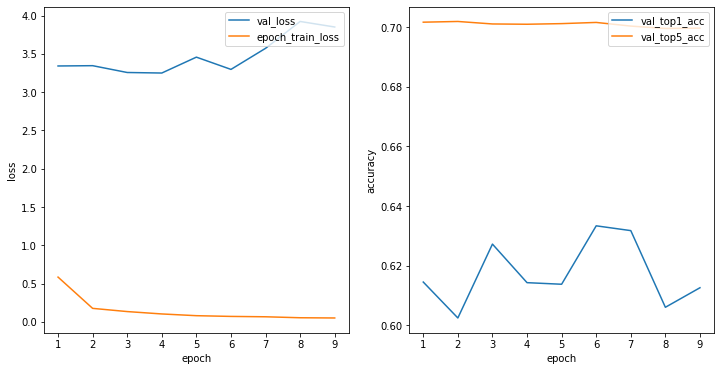

In [19]:
 plot_training_data(res_tr['train_log_file'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9889, device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(1., device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 12/12 [00:07<00:00,  2.57it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9427, device='cuda:0'),
 'top5_acc': tensor(0.9970, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 12/12 [00:07<00:00,  1.68it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 6/6 [00:03<00:00,  1.46it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9632, device='cuda:0'),
 'top5_acc': tensor(0.9991, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.8619, device='cuda:0'),
 'top5_acc': tensor(0.9945, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9844, device='cuda:0'),
 'top5_acc': tensor(0.9907, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9576, device='cuda:0'),
 'top5_acc': tensor(0.9960, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:01<00:00,  1.32s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.8723, device='cuda:0'),
 'top5_acc': tensor(0.9948, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.6293, device='cuda:0'),
 'top5_acc': tensor(0.9911, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.8021, device='cuda:0'),
 'top5_acc': tensor(0.9950, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.8938, device='cuda:0'),
 'top5_acc': tensor(0.9927, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing:  75%|███████▌  | 3/4 [00:02<00:01,  1.12s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.8177, device='cuda:0'),
 'top5_acc': tensor(0.9967, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9091, device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.8993, device='cuda:0'),
 'top5_acc': tensor(0.9892, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.7622, device='cuda:0'),
 'top5_acc': tensor(0.9974, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(1., device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9673, device='cuda:0'),
 'top5_acc': tensor(0.9940, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.7843, device='cuda:0'),
 'top5_acc': tensor(0.9987, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9365, device='cuda:0'),
 'top5_acc': tensor(0.9920, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


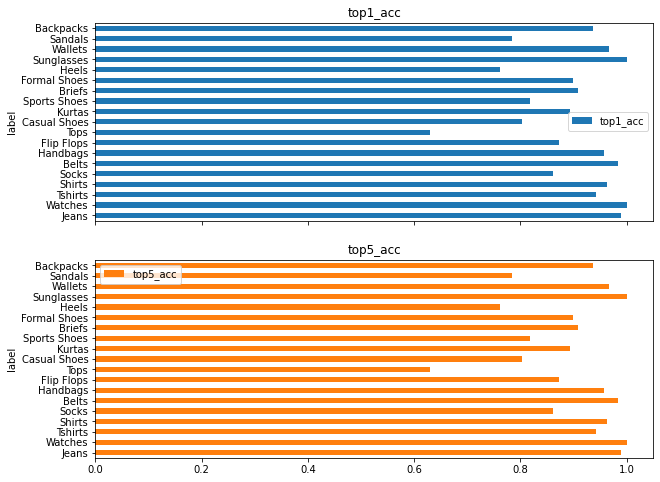

In [20]:
res_acc = plot_top_for_each_class(
    class_labels[train_df['class'].unique()],
    val_df, res_tr['best_model_path'],
)

In [21]:
res_tst = test(dm, res_tr['best_model_path'])
results_balancing_methods['initial'] = {'train': res_tr, 'test': res_tst[0], 'accuracies': res_acc}

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Testing: 100%|██████████| 54/54 [00:32<00:00,  2.08it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.6334, device='cuda:0'),
 'top5_acc': tensor(0.7016, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 54/54 [00:32<00:00,  1.66it/s]


#### Balance classes in train to have equal frequencies with upsampling

In [22]:
train_df = pd.read_pickle(os.path.join(DATA_DIR, 'train_top20.p'))
val_df = pd.read_pickle(os.path.join(DATA_DIR, 'test.p'))

In [23]:
# produce uniform class frequencies
freq = get_class_freq(train_df)
freq = freq.where(freq != 0).dropna()
freq = freq.apply(lambda x: 1 / len(freq.index))
# calculate upsampling counts for uniform freqiencies
#up_counts = get_upsampling_counts(train_df, freq)
# upsample the dataset to roughly contain all previous data but at uniform frequencies
#train_df = get_resampled_data(train_df, freq, (len(train_df) + up_counts.sum()) / len(train_df))
train_df = get_resampled_data(train_df, freq, 1.0)

In [24]:
#train_df['class'].value_counts().plot(kind='barh')

In [25]:
dm = FashionDataModule(train_df, val_df, batch_size)

In [26]:
res_tr = train(dm, 'resampling_equal', max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name      | Type             | Params | In sizes         | Out sizes
------------------------------------------------------------------------------
0 | model     | ResNet           | 11 M   | [1, 3, 224, 224] | [1, 142] 
1 | criterion | CrossEntropyLoss | 0      | ?                | ?        

Finding best initial lr: 100%|██████████| 100/100 [03:00<00:00,  3.04s/it]Saving latest checkpoint..
Set SLURM handle signals.

  | Name      | Type             | Params | In sizes         | Out sizes
------------------------------------------------------------------------------
0 | model     | ResNet           | 11 M   | [1, 3, 224, 224] | [1, 142] 
1 | criterion | CrossEntropyLoss | 0      | ?                | ?        


Epoch 1:  47%|████▋     | 47/101 [00:51<00:59,  1.10s/it, loss=0.210, v_num=qual, val_loss=2.48e+8]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 101/101 [01:26<00:00,  1.17it/s, loss=0.210, v_num=qual, val_loss=2.48e+8]


Epoch 00001: val_checkpoint_on reached 0.40952 (best 0.40952), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=1-val_loss=3.39.ckpt as top 1


Epoch 2:  47%|████▋     | 47/101 [00:51<00:59,  1.10s/it, loss=0.112, v_num=qual, val_loss=3.39] 
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 101/101 [01:26<00:00,  1.17it/s, loss=0.112, v_num=qual, val_loss=3.39]


Epoch 00002: val_checkpoint_on reached 0.38278 (best 0.38278), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=2-val_loss=3.38.ckpt as top 1


Epoch 3:  47%|████▋     | 47/101 [00:52<01:00,  1.11s/it, loss=0.076, v_num=qual, val_loss=3.38] 
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 101/101 [01:27<00:00,  1.16it/s, loss=0.076, v_num=qual, val_loss=3.38]


Epoch 00003: val_checkpoint_on  was not in top 1


Epoch 4:  47%|████▋     | 47/101 [00:52<00:59,  1.11s/it, loss=0.062, v_num=qual, val_loss=3.53] 
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 101/101 [01:27<00:00,  1.16it/s, loss=0.062, v_num=qual, val_loss=3.53]


Epoch 00004: val_checkpoint_on  was not in top 1


Epoch 5:  47%|████▋     | 47/101 [00:51<00:59,  1.11s/it, loss=0.047, v_num=qual, val_loss=3.54] 
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 101/101 [01:27<00:00,  1.16it/s, loss=0.047, v_num=qual, val_loss=3.54]


Epoch 00005: val_checkpoint_on reached 0.37733 (best 0.37733), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=5-val_loss=3.62.ckpt as top 1


Epoch 6:  47%|████▋     | 47/101 [00:52<01:00,  1.12s/it, loss=0.044, v_num=qual, val_loss=3.62] 
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 101/101 [01:27<00:00,  1.15it/s, loss=0.044, v_num=qual, val_loss=3.62]


Epoch 00006: val_checkpoint_on  was not in top 1


Epoch 7:  47%|████▋     | 47/101 [00:52<01:00,  1.12s/it, loss=0.033, v_num=qual, val_loss=3.65] 
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 101/101 [01:27<00:00,  1.16it/s, loss=0.033, v_num=qual, val_loss=3.65]


Epoch 00007: val_checkpoint_on  was not in top 1


Epoch 8:  47%|████▋     | 47/101 [00:52<01:00,  1.12s/it, loss=0.027, v_num=qual, val_loss=3.49] 
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 101/101 [01:27<00:00,  1.15it/s, loss=0.027, v_num=qual, val_loss=3.49]


Epoch 00008: val_checkpoint_on reached 0.37135 (best 0.37135), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=8-val_loss=3.84.ckpt as top 1


Epoch 9:  47%|████▋     | 47/101 [00:52<00:59,  1.11s/it, loss=0.029, v_num=qual, val_loss=3.84] 
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 101/101 [01:26<00:00,  1.16it/s, loss=0.029, v_num=qual, val_loss=3.84]


Epoch 00009: val_checkpoint_on  was not in top 1


Epoch 9: 100%|██████████| 101/101 [01:26<00:00,  1.16it/s, loss=0.029, v_num=qual, val_loss=3.87]
                                                           

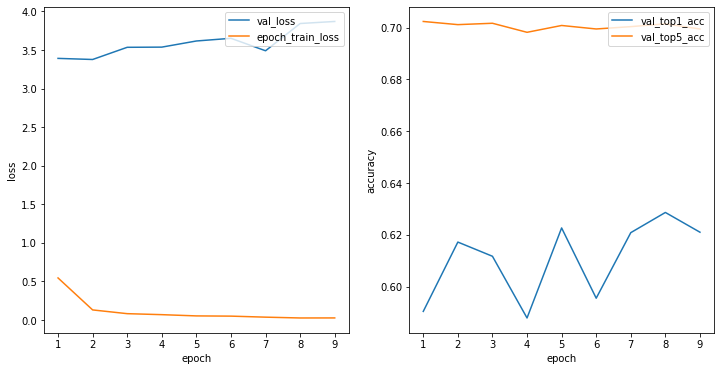

In [27]:
plot_training_data(res_tr['train_log_file'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.8961, device='cuda:0'),
 'top5_acc': tensor(0.9888, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing:  75%|███████▌  | 3/4 [00:02<00:01,  1.14s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9121, device='cuda:0'),
 'top5_acc': tensor(0.9967, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9557, device='cuda:0'),
 'top5_acc': tensor(0.9956, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 6/6 [00:04<00:00,  1.44it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9346, device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(1., device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9363, device='cuda:0'),
 'top5_acc': tensor(0.9906, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.7413, device='cuda:0'),
 'top5_acc': tensor(0.9919, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(1., device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9458, device='cuda:0'),
 'top5_acc': tensor(0.9774, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:01<00:00,  1.32s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.7906, device='cuda:0'),
 'top5_acc': tensor(0.9935, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9815, device='cuda:0'),
 'top5_acc': tensor(0.9926, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9751, device='cuda:0'),
 'top5_acc': tensor(0.9907, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 12/12 [00:07<00:00,  2.40it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9200, device='cuda:0'),
 'top5_acc': tensor(0.9987, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 12/12 [00:07<00:00,  1.58it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9412, device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.8294, device='cuda:0'),
 'top5_acc': tensor(0.9987, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9317, device='cuda:0'),
 'top5_acc': tensor(0.9892, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 4/4 [00:02<00:00,  1.10it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.6762, device='cuda:0'),
 'top5_acc': tensor(0.9937, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 4/4 [00:02<00:00,  1.33it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9911, device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9779, device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


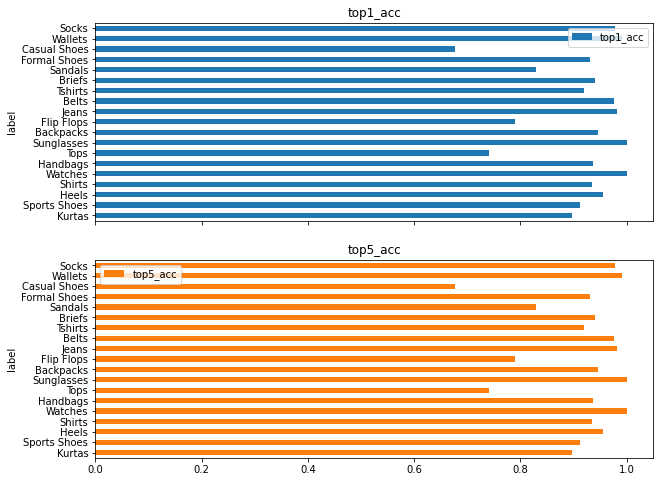

In [28]:
res_acc = plot_top_for_each_class(
    class_labels[train_df['class'].unique()],
    val_df, res_tr['best_model_path'],
)

In [29]:
res_tst = test(dm, res_tr['best_model_path'])
results_balancing_methods['resampling_equal'] = {'train': res_tr, 'test': res_tst[0], 'accuracies': res_acc}

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Testing: 100%|██████████| 54/54 [00:31<00:00,  2.24it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.6286, device='cuda:0'),
 'top5_acc': tensor(0.7014, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 54/54 [00:31<00:00,  1.70it/s]


#### Balance classes in train to match test with upsampling

In [30]:
train_df = pd.read_pickle(os.path.join(DATA_DIR, 'train_top20.p'))
val_df = pd.read_pickle(os.path.join(DATA_DIR, 'test.p'))
freq = get_class_freq(val_df, 142)
train_df = get_resampled_data(train_df, freq)
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [31]:
#train_df['class'].value_counts().head(25).plot(kind='barh')

In [32]:
#val_df['class'].value_counts().head(25).plot(kind='barh')

In [32]:
dm = FashionDataModule(train_df, val_df, batch_size)

In [33]:
res_tr = train(dm, 'resampling_to_test', max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name      | Type             | Params | In sizes         | Out sizes
------------------------------------------------------------------------------
0 | model     | ResNet           | 11 M   | [1, 3, 224, 224] | [1, 142] 
1 | criterion | CrossEntropyLoss | 0      | ?                | ?        


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Finding best initial lr:   1%|          | 1/100 [00:00<01:35,  1.03it/s]

Finding best initial lr:   2%|▏         | 2/100 [00:01<01:31,  1.07it/s]

Finding best initial lr:   3%|▎         | 3/100 [00:02<01:30,  1.07it/s]

Finding best initial lr:   4%|▍         | 4/100 [00:04<01:58,  1.23s/it]

Finding best initial lr:   5%|▌         | 5/100 [00:05<01:48,  1.14s/it]

Finding best initial lr:   6%|▌         | 6/100 [00:06<01:39,  1.06s/it]

Finding best initial lr:   7%|▋         | 7/100 [00:07<01:35,  1

Epoch 1:  47%|████▋     | 47/101 [00:51<00:58,  1.09s/it, loss=0.233, v_num=test, val_loss=3.22e+9]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 101/101 [01:26<00:00,  1.17it/s, loss=0.233, v_num=test, val_loss=3.22e+9]


Epoch 00001: val_checkpoint_on reached 0.40340 (best 0.40340), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=1-val_loss=3.58.ckpt as top 1


Epoch 2:  47%|████▋     | 47/101 [00:51<00:59,  1.10s/it, loss=0.129, v_num=test, val_loss=3.58] 
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 101/101 [01:26<00:00,  1.17it/s, loss=0.129, v_num=test, val_loss=3.58]


Epoch 00002: val_checkpoint_on reached 0.39271 (best 0.39271), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=2-val_loss=3.62.ckpt as top 1


Epoch 3:  47%|████▋     | 47/101 [00:51<00:59,  1.10s/it, loss=0.088, v_num=test, val_loss=3.62] 
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 101/101 [01:26<00:00,  1.17it/s, loss=0.088, v_num=test, val_loss=3.62]


Epoch 00003: val_checkpoint_on reached 0.37879 (best 0.37879), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=3-val_loss=3.31.ckpt as top 1


Epoch 4:  47%|████▋     | 47/101 [00:51<00:59,  1.10s/it, loss=0.074, v_num=test, val_loss=3.31] 
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 101/101 [01:26<00:00,  1.17it/s, loss=0.074, v_num=test, val_loss=3.31]


Epoch 00004: val_checkpoint_on reached 0.36887 (best 0.36887), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=4-val_loss=3.51.ckpt as top 1


Epoch 5:  47%|████▋     | 47/101 [00:51<00:59,  1.10s/it, loss=0.052, v_num=test, val_loss=3.51] 
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 101/101 [01:26<00:00,  1.17it/s, loss=0.052, v_num=test, val_loss=3.51]


Epoch 00005: val_checkpoint_on  was not in top 1


Epoch 6:  47%|████▋     | 47/101 [00:51<00:58,  1.09s/it, loss=0.050, v_num=test, val_loss=3.7] 
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 101/101 [01:25<00:00,  1.18it/s, loss=0.050, v_num=test, val_loss=3.7]


Epoch 00006: val_checkpoint_on  was not in top 1


Epoch 7:  47%|████▋     | 47/101 [00:52<01:00,  1.11s/it, loss=0.043, v_num=test, val_loss=3.72] 
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 101/101 [01:26<00:00,  1.17it/s, loss=0.043, v_num=test, val_loss=3.72]


Epoch 00007: val_checkpoint_on  was not in top 1


Epoch 8:  47%|████▋     | 47/101 [00:51<00:58,  1.09s/it, loss=0.034, v_num=test, val_loss=3.72] 
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 101/101 [01:25<00:00,  1.17it/s, loss=0.034, v_num=test, val_loss=3.72]


Epoch 00008: val_checkpoint_on reached 0.36707 (best 0.36707), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=8-val_loss=3.81.ckpt as top 1


Epoch 9:  47%|████▋     | 47/101 [00:51<00:59,  1.10s/it, loss=0.029, v_num=test, val_loss=3.81] 
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 101/101 [01:26<00:00,  1.17it/s, loss=0.029, v_num=test, val_loss=3.81]


Epoch 00009: val_checkpoint_on  was not in top 1


Epoch 9: 100%|██████████| 101/101 [01:26<00:00,  1.17it/s, loss=0.029, v_num=test, val_loss=3.71]
                                                           

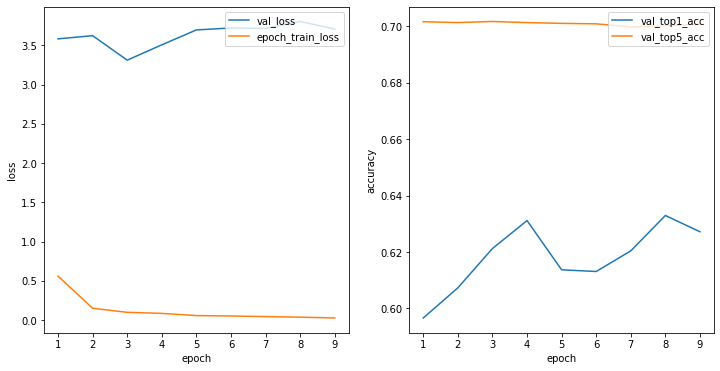

In [34]:
plot_training_data(res_tr['train_log_file'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Testing: 100%|██████████| 12/12 [00:07<00:00,  2.46it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9743, device='cuda:0'),
 'top5_acc': tensor(0.9980, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 12/12 [00:07<00:00,  1.57it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9323, device='cuda:0'),
 'top5_acc': tensor(0.9920, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.8930, device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.8322, device='cuda:0'),
 'top5_acc': tensor(0.9956, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9844, device='cuda:0'),
 'top5_acc': tensor(0.9907, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:01<00:00,  1.31s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.7938, device='cuda:0'),
 'top5_acc': tensor(0.9987, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.8633, device='cuda:0'),
 'top5_acc': tensor(0.9856, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9889, device='cuda:0'),
 'top5_acc': tensor(0.9963, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9662, device='cuda:0'),
 'top5_acc': tensor(0.9983, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9419, device='cuda:0'),
 'top5_acc': tensor(0.9984, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.3717, device='cuda:0'),
 'top5_acc': tensor(0.9651, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.8953, device='cuda:0'),
 'top5_acc': tensor(0.9691, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 4/4 [00:02<00:00,  1.09it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.7863, device='cuda:0'),
 'top5_acc': tensor(0.9893, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9911, device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing:  75%|███████▌  | 3/4 [00:02<00:01,  1.15s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.8216, device='cuda:0'),
 'top5_acc': tensor(0.9948, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:01<00:00,  1.32s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9376, device='cuda:0'),
 'top5_acc': tensor(0.9974, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.8840, device='cuda:0'),
 'top5_acc': tensor(0.9890, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9833, device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(1., device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


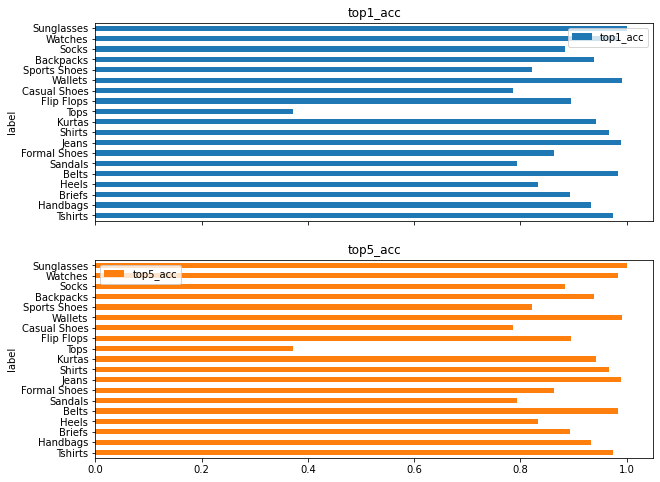

In [35]:
res_acc = plot_top_for_each_class(
    class_labels[train_df['class'].unique()],
    val_df, res_tr['best_model_path'],
)

In [36]:
res_tst = test(dm, res_tr['best_model_path'])
results_balancing_methods['resampling_to_test'] = {'train': res_tr, 'test': res_tst[0], 'accuracies': res_acc}

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Testing: 100%|██████████| 54/54 [00:31<00:00,  2.22it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.6329, device='cuda:0'),
 'top5_acc': tensor(0.7002, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 54/54 [00:32<00:00,  1.68it/s]


#### Balance classes with weighting to match test

In [37]:
train_df = pd.read_pickle(os.path.join(DATA_DIR, 'train_top20.p'))
val_df = pd.read_pickle(os.path.join(DATA_DIR, 'test.p'))

In [38]:
freq_val = get_class_freq(val_df, 142)
freq_tr = get_class_freq(train_df)

In [39]:
weights = freq_val.to_frame(0).apply(lambda x: 1./x if x.name in freq_tr.index else 0, axis=1)
weights = weights / weights.sum()

In [40]:
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weights.to_numpy()))

In [41]:
dm = FashionDataModule(train_df, val_df, batch_size)

In [42]:
res_tr = train(dm, 'weighting_to_test', criterion=criterion, max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name      | Type             | Params | In sizes         | Out sizes
------------------------------------------------------------------------------
0 | model     | ResNet           | 11 M   | [1, 3, 224, 224] | [1, 142] 
1 | criterion | CrossEntropyLoss | 0      | ?                | ?        



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]


Finding best initial lr:   1%|          | 1/100 [00:00<01:34,  1.05it/s]


Finding best initial lr:   2%|▏         | 2/100 [00:01<01:30,  1.08it/s]


Finding best initial lr:   3%|▎         | 3/100 [00:02<01:29,  1.08it/s]


Finding best initial lr:   4%|▍         | 4/100 [00:04<02:03,  1.29s/it]


Finding best initial lr:   5%|▌         | 5/100 [00:05<01:52,  1.18s/it]


Finding best initial lr:   6%|▌         | 6/100 [00:06<01:42,  1.09s/it]


Finding best initial lr:   7%|▋         | 7/100 [00:07<0

Epoch 1:  47%|████▋     | 47/101 [00:53<01:01,  1.15s/it, loss=0.233, v_num=test, val_loss=9.55e+9]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 101/101 [01:28<00:00,  1.15it/s, loss=0.233, v_num=test, val_loss=9.55e+9]


Epoch 00001: val_checkpoint_on reached 0.70438 (best 0.70438), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=1-val_loss=1.17.ckpt as top 1


Epoch 2:  47%|████▋     | 47/101 [00:54<01:02,  1.15s/it, loss=0.089, v_num=test, val_loss=1.17] 
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 101/101 [01:28<00:00,  1.15it/s, loss=0.089, v_num=test, val_loss=1.17]


Epoch 00002: val_checkpoint_on reached 0.42051 (best 0.42051), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=2-val_loss=0.80.ckpt as top 1


Epoch 3:  47%|████▋     | 47/101 [00:54<01:02,  1.16s/it, loss=0.054, v_num=test, val_loss=0.803] 
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 101/101 [01:28<00:00,  1.14it/s, loss=0.054, v_num=test, val_loss=0.803]


Epoch 00003: val_checkpoint_on reached 0.39701 (best 0.39701), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=3-val_loss=0.72.ckpt as top 1


Epoch 4:  47%|████▋     | 47/101 [00:54<01:02,  1.16s/it, loss=0.041, v_num=test, val_loss=0.72] 
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 101/101 [01:28<00:00,  1.14it/s, loss=0.041, v_num=test, val_loss=0.72]


Epoch 00004: val_checkpoint_on reached 0.38237 (best 0.38237), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=4-val_loss=0.68.ckpt as top 1


Epoch 5:  47%|████▋     | 47/101 [00:54<01:02,  1.16s/it, loss=0.032, v_num=test, val_loss=0.684] 
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 101/101 [01:28<00:00,  1.14it/s, loss=0.032, v_num=test, val_loss=0.684]


Epoch 00005: val_checkpoint_on reached 0.37359 (best 0.37359), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=5-val_loss=0.69.ckpt as top 1


Epoch 6:  47%|████▋     | 47/101 [00:54<01:02,  1.15s/it, loss=0.026, v_num=test, val_loss=0.688] 
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 101/101 [01:28<00:00,  1.14it/s, loss=0.026, v_num=test, val_loss=0.688]


Epoch 00006: val_checkpoint_on  was not in top 1


Epoch 7:  47%|████▋     | 47/101 [00:54<01:02,  1.16s/it, loss=0.021, v_num=test, val_loss=0.716] 
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 101/101 [01:28<00:00,  1.14it/s, loss=0.021, v_num=test, val_loss=0.716]


Epoch 00007: val_checkpoint_on reached 0.36649 (best 0.36649), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=7-val_loss=0.67.ckpt as top 1


Epoch 8:  47%|████▋     | 47/101 [00:54<01:02,  1.16s/it, loss=0.019, v_num=test, val_loss=0.666] 
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 101/101 [01:28<00:00,  1.14it/s, loss=0.019, v_num=test, val_loss=0.666]


Epoch 00008: val_checkpoint_on  was not in top 1


Epoch 9:  47%|████▋     | 47/101 [00:54<01:02,  1.15s/it, loss=0.015, v_num=test, val_loss=0.714] 
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 101/101 [01:28<00:00,  1.14it/s, loss=0.015, v_num=test, val_loss=0.714]


Epoch 00009: val_checkpoint_on  was not in top 1


Epoch 9: 100%|██████████| 101/101 [01:28<00:00,  1.14it/s, loss=0.015, v_num=test, val_loss=0.702]
                                                           

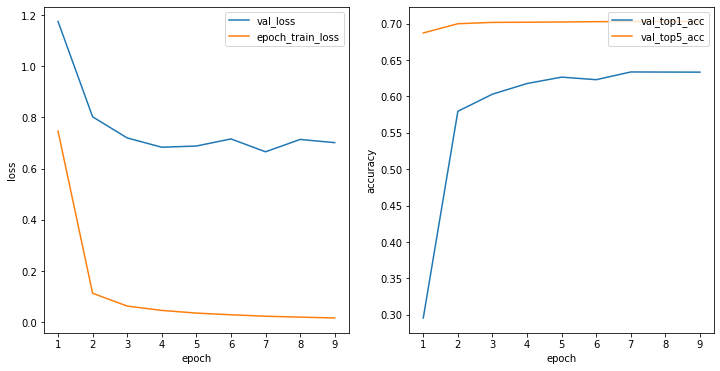

In [43]:
plot_training_data(res_tr['train_log_file'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9889, device='cuda:0'),
 'top5_acc': tensor(0.9963, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(1., device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 12/12 [00:07<00:00,  2.55it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.8877, device='cuda:0'),
 'top5_acc': tensor(0.9989, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 12/12 [00:07<00:00,  1.66it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9566, device='cuda:0'),
 'top5_acc': tensor(0.9987, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9503, device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9844, device='cuda:0'),
 'top5_acc': tensor(0.9907, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9588, device='cuda:0'),
 'top5_acc': tensor(0.9987, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9106, device='cuda:0'),
 'top5_acc': tensor(0.9922, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.7775, device='cuda:0'),
 'top5_acc': tensor(0.9987, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Testing: 100%|██████████| 4/4 [00:02<00:00,  1.07it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.8435, device='cuda:0'),
 'top5_acc': tensor(0.9956, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9638, device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing:  75%|███████▌  | 3/4 [00:02<00:01,  1.15s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.7832, device='cuda:0'),
 'top5_acc': tensor(0.9961, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9679, device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.7554, device='cuda:0'),
 'top5_acc': tensor(0.9964, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9483, device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(1., device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9821, device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.7969, device='cuda:0'),
 'top5_acc': tensor(0.9974, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9630, device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


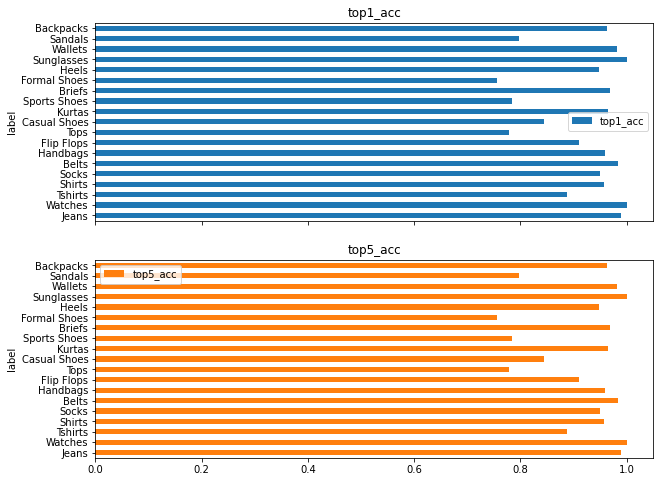

In [44]:
res_acc = plot_top_for_each_class(
    class_labels[train_df['class'].unique()],
    val_df, res_tr['best_model_path'],
    criterion
)

In [45]:
res_tst = test(dm, res_tr['best_model_path'], criterion=criterion)
results_balancing_methods['weighting_to_test'] = {'train': res_tr, 'test': res_tst[0], 'accuracies': res_acc}

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Testing: 100%|██████████| 54/54 [00:32<00:00,  2.14it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.6335, device='cuda:0'),
 'top5_acc': tensor(0.7029, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 54/54 [00:32<00:00,  1.68it/s]


#### Balance classes with weighting to equal loss contribution

In [46]:
train_df = pd.read_pickle(os.path.join(DATA_DIR, 'train_top20.p'))
val_df = pd.read_pickle(os.path.join(DATA_DIR, 'test.p'))

In [47]:
weights = get_class_weights(train_df, 142)

In [48]:
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weights.to_numpy()))

In [49]:
dm = FashionDataModule(train_df, val_df, batch_size)

In [50]:
res_tr = train(dm, 'weighting', criterion, max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name      | Type             | Params | In sizes         | Out sizes
------------------------------------------------------------------------------
0 | model     | ResNet           | 11 M   | [1, 3, 224, 224] | [1, 142] 
1 | criterion | CrossEntropyLoss | 0      | ?                | ?        




Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]



Finding best initial lr:   1%|          | 1/100 [00:01<01:42,  1.04s/it]



Finding best initial lr:   2%|▏         | 2/100 [00:01<01:36,  1.02it/s]



Finding best initial lr:   3%|▎         | 3/100 [00:02<01:34,  1.03it/s]



Finding best initial lr:   4%|▍         | 4/100 [00:04<02:06,  1.32s/it]



Finding best initial lr:   5%|▌         | 5/100 [00:05<01:54,  1.21s/it]



Finding best initial lr:   6%|▌         | 6/100 [00:06<01:43,  1.10s/it]



Finding best initial lr:   7%|▋         | 7/100 

Epoch 1:  47%|████▋     | 47/101 [00:54<01:03,  1.17s/it, loss=0.242, v_num=ting, val_loss=2.94e+9]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 101/101 [01:29<00:00,  1.13it/s, loss=0.242, v_num=ting, val_loss=2.94e+9]


Epoch 00001: val_checkpoint_on reached 0.39749 (best 0.39749), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=1-val_loss=0.42.ckpt as top 1


Epoch 2:  47%|████▋     | 47/101 [00:54<01:02,  1.16s/it, loss=0.140, v_num=ting, val_loss=0.418] 
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 101/101 [01:28<00:00,  1.14it/s, loss=0.140, v_num=ting, val_loss=0.418]


Epoch 00002: val_checkpoint_on reached 0.38590 (best 0.38590), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=2-val_loss=0.35.ckpt as top 1


Epoch 3:  47%|████▋     | 47/101 [00:54<01:02,  1.16s/it, loss=0.101, v_num=ting, val_loss=0.354] 
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 101/101 [01:28<00:00,  1.14it/s, loss=0.101, v_num=ting, val_loss=0.354]


Epoch 00003: val_checkpoint_on reached 0.37452 (best 0.37452), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=3-val_loss=0.36.ckpt as top 1


Epoch 4:  47%|████▋     | 47/101 [00:54<01:02,  1.15s/it, loss=0.088, v_num=ting, val_loss=0.363] 
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 101/101 [01:28<00:00,  1.14it/s, loss=0.088, v_num=ting, val_loss=0.363]


Epoch 00004: val_checkpoint_on  was not in top 1


Epoch 5:  47%|████▋     | 47/101 [00:53<01:02,  1.15s/it, loss=0.071, v_num=ting, val_loss=0.467] 
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 101/101 [01:28<00:00,  1.15it/s, loss=0.071, v_num=ting, val_loss=0.467]


Epoch 00005: val_checkpoint_on  was not in top 1


Epoch 6:  47%|████▋     | 47/101 [00:54<01:02,  1.16s/it, loss=0.069, v_num=ting, val_loss=0.348] 
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 101/101 [01:29<00:00,  1.13it/s, loss=0.069, v_num=ting, val_loss=0.348]


Epoch 00006: val_checkpoint_on  was not in top 1


Epoch 7:  47%|████▋     | 47/101 [00:54<01:02,  1.15s/it, loss=0.061, v_num=ting, val_loss=0.546] 
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 101/101 [01:28<00:00,  1.14it/s, loss=0.061, v_num=ting, val_loss=0.546]


Epoch 00007: val_checkpoint_on  was not in top 1


Epoch 8:  47%|████▋     | 47/101 [00:54<01:02,  1.15s/it, loss=0.050, v_num=ting, val_loss=0.372] 
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 101/101 [01:28<00:00,  1.14it/s, loss=0.050, v_num=ting, val_loss=0.372]


Epoch 00008: val_checkpoint_on reached 0.37139 (best 0.37139), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=8-val_loss=0.37.ckpt as top 1


Epoch 9:  47%|████▋     | 47/101 [00:54<01:03,  1.17s/it, loss=0.046, v_num=ting, val_loss=0.369] 
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 101/101 [01:28<00:00,  1.13it/s, loss=0.046, v_num=ting, val_loss=0.369]


Epoch 00009: val_checkpoint_on reached 0.36472 (best 0.36472), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=9-val_loss=0.39.ckpt as top 1


Epoch 9: 100%|██████████| 101/101 [01:29<00:00,  1.13it/s, loss=0.046, v_num=ting, val_loss=0.393]
                                                           

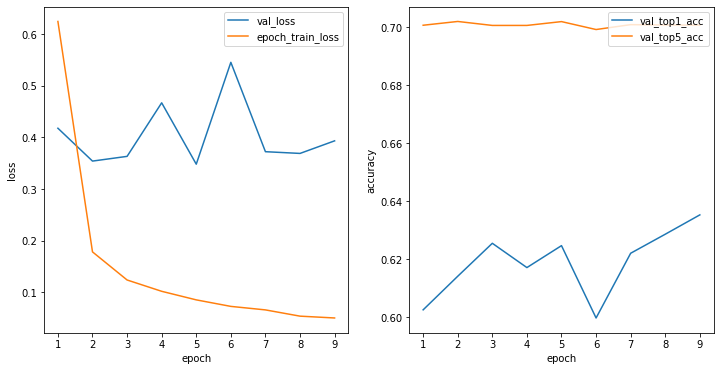

In [51]:
plot_training_data(res_tr['train_log_file'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9852, device='cuda:0'),
 'top5_acc': tensor(0.9926, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(1., device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 12/12 [00:07<00:00,  2.51it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9349, device='cuda:0'),
 'top5_acc': tensor(0.9959, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 12/12 [00:07<00:00,  1.61it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9658, device='cuda:0'),
 'top5_acc': tensor(0.9996, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9448, device='cuda:0'),
 'top5_acc': tensor(0.9945, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9907, device='cuda:0'),
 'top5_acc': tensor(0.9907, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9709, device='cuda:0'),
 'top5_acc': tensor(0.9934, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:01<00:00,  1.31s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.8797, device='cuda:0'),
 'top5_acc': tensor(0.9691, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.6330, device='cuda:0'),
 'top5_acc': tensor(0.9864, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 4/4 [00:02<00:00,  1.11it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.8044, device='cuda:0'),
 'top5_acc': tensor(0.9937, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9622, device='cuda:0'),
 'top5_acc': tensor(0.9956, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Testing:  75%|███████▌  | 3/4 [00:02<00:01,  1.16s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.7148, device='cuda:0'),
 'top5_acc': tensor(0.9948, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9840, device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.6079, device='cuda:0'),
 'top5_acc': tensor(0.9784, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9579, device='cuda:0'),
 'top5_acc': tensor(0.9970, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(1., device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9643, device='cuda:0'),
 'top5_acc': tensor(0.9940, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.7526, device='cuda:0'),
 'top5_acc': tensor(0.9987, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9658, device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


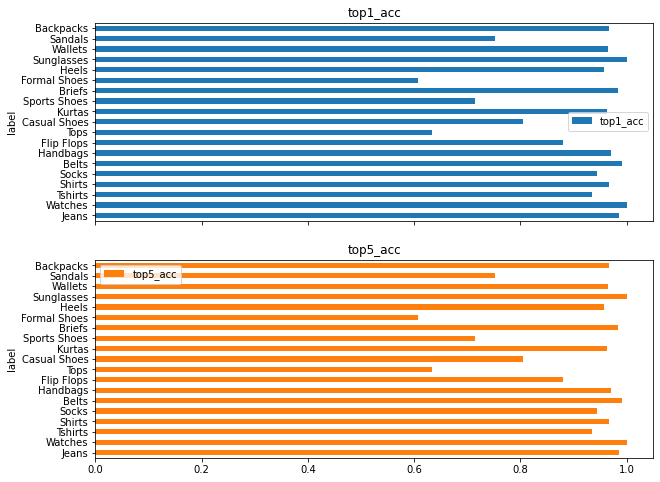

In [52]:
res_acc = plot_top_for_each_class(
    class_labels[train_df['class'].unique()],
    val_df, res_tr['best_model_path'],
    criterion
)

In [53]:
res_tst = test(dm, res_tr['best_model_path'], criterion)
results_balancing_methods['weighting_equal'] = {'train': res_tr, 'test': res_tst[0], 'accuracies': res_acc}

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Testing: 100%|██████████| 54/54 [00:31<00:00,  2.21it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.6353, device='cuda:0'),
 'top5_acc': tensor(0.7008, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 54/54 [00:31<00:00,  1.71it/s]


#### Focal Loss

In [54]:
train_df = pd.read_pickle(os.path.join(DATA_DIR, 'train_top20.p'))
val_df = pd.read_pickle(os.path.join(DATA_DIR, 'test.p'))

In [55]:
dm = FashionDataModule(train_df, val_df, batch_size)

In [56]:
criterion = FocalLoss(alpha=100, gamma=4, logits=True)

In [57]:
res_tr = train(dm, 'focal_loss', criterion, max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name      | Type      | Params | In sizes         | Out sizes
-----------------------------------------------------------------------
0 | model     | ResNet    | 11 M   | [1, 3, 224, 224] | [1, 142] 
1 | criterion | FocalLoss | 0      | ?                | ?        





Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]




Finding best initial lr:   1%|          | 1/100 [00:01<01:47,  1.09s/it]




Finding best initial lr:   2%|▏         | 2/100 [00:02<01:42,  1.05s/it]




Finding best initial lr:   3%|▎         | 3/100 [00:02<01:38,  1.01s/it]




Finding best initial lr:   4%|▍         | 4/100 [00:05<02:06,  1.32s/it]




Finding best initial lr:   5%|▌         | 5/100 [00:05<01:54,  1.20s/it]




Finding best initial lr:   6%|▌         | 6/100 [00:06<01:43,  1.10s/it]




Finding best initial lr:   7%|▋         | 7/100 [00:07<01:37,  1.05s

Epoch 1:  47%|████▋     | 47/101 [00:53<01:01,  1.13s/it, loss=0.048, v_num=loss, val_loss=4.04e+9]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 101/101 [01:27<00:00,  1.16it/s, loss=0.048, v_num=loss, val_loss=4.04e+9]


Epoch 00001: val_checkpoint_on reached 0.41754 (best 0.41754), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=1-val_loss=0.37.ckpt as top 1


Epoch 2:  47%|████▋     | 47/101 [00:53<01:01,  1.14s/it, loss=0.025, v_num=loss, val_loss=0.369] 
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 101/101 [01:27<00:00,  1.16it/s, loss=0.025, v_num=loss, val_loss=0.369]


Epoch 00002: val_checkpoint_on reached 0.38484 (best 0.38484), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=2-val_loss=0.40.ckpt as top 1


Epoch 3:  47%|████▋     | 47/101 [00:53<01:01,  1.14s/it, loss=0.019, v_num=loss, val_loss=0.399] 
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 101/101 [01:27<00:00,  1.16it/s, loss=0.019, v_num=loss, val_loss=0.399]


Epoch 00003: val_checkpoint_on reached 0.37446 (best 0.37446), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=3-val_loss=0.40.ckpt as top 1


Epoch 4:  47%|████▋     | 47/101 [00:53<01:02,  1.15s/it, loss=0.015, v_num=loss, val_loss=0.402] 
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 101/101 [01:27<00:00,  1.15it/s, loss=0.015, v_num=loss, val_loss=0.402]


Epoch 00004: val_checkpoint_on reached 0.36960 (best 0.36960), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=4-val_loss=0.42.ckpt as top 1


Epoch 5:  47%|████▋     | 47/101 [00:54<01:02,  1.15s/it, loss=0.013, v_num=loss, val_loss=0.418] 
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 101/101 [01:27<00:00,  1.15it/s, loss=0.013, v_num=loss, val_loss=0.418]


Epoch 00005: val_checkpoint_on reached 0.36729 (best 0.36729), saving model to /gpfs/data/home/r.schutski/few_shot_learning/notebooks/lightning_logs/372101/checkpoints/epoch=5-val_loss=0.42.ckpt as top 1


Epoch 6:  47%|████▋     | 47/101 [00:54<01:02,  1.16s/it, loss=0.010, v_num=loss, val_loss=0.423] 
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 101/101 [01:28<00:00,  1.15it/s, loss=0.010, v_num=loss, val_loss=0.423]


Epoch 00006: val_checkpoint_on  was not in top 1


Epoch 7:  47%|████▋     | 47/101 [00:54<01:02,  1.15s/it, loss=0.009, v_num=loss, val_loss=0.434] 
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 101/101 [01:27<00:00,  1.15it/s, loss=0.009, v_num=loss, val_loss=0.434]


Epoch 00007: val_checkpoint_on  was not in top 1


Epoch 8:  47%|████▋     | 47/101 [00:53<01:01,  1.15s/it, loss=0.009, v_num=loss, val_loss=0.459] 
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 101/101 [01:27<00:00,  1.15it/s, loss=0.009, v_num=loss, val_loss=0.459]


Epoch 00008: val_checkpoint_on  was not in top 1


Epoch 9:  47%|████▋     | 47/101 [00:54<01:02,  1.15s/it, loss=0.009, v_num=loss, val_loss=0.485] 
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 101/101 [01:27<00:00,  1.15it/s, loss=0.009, v_num=loss, val_loss=0.485]


Epoch 00009: val_checkpoint_on  was not in top 1


Epoch 9: 100%|██████████| 101/101 [01:28<00:00,  1.15it/s, loss=0.009, v_num=loss, val_loss=0.488]
                                                           

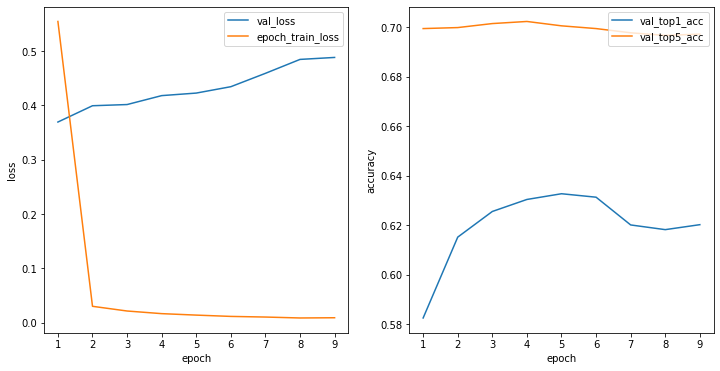

In [58]:
plot_training_data(res_tr['train_log_file'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9742, device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(1., device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 12/12 [00:07<00:00,  2.47it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9186, device='cuda:0'),
 'top5_acc': tensor(0.9950, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 12/12 [00:07<00:00,  1.57it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9918, device='cuda:0'),
 'top5_acc': tensor(0.9991, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9116, device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9907, device='cuda:0'),
 'top5_acc': tensor(0.9907, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9669, device='cuda:0'),
 'top5_acc': tensor(0.9960, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.8514, device='cuda:0'),
 'top5_acc': tensor(0.9652, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.6486, device='cuda:0'),
 'top5_acc': tensor(0.9844, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Testing: 100%|██████████| 4/4 [00:02<00:00,  1.06it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.7966, device='cuda:0'),
 'top5_acc': tensor(0.9930, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9161, device='cuda:0'),
 'top5_acc': tensor(0.9971, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Testing:  75%|███████▌  | 3/4 [00:02<00:01,  1.17s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9023, device='cuda:0'),
 'top5_acc': tensor(0.9967, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9679, device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.7626, device='cuda:0'),
 'top5_acc': tensor(0.9892, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.8109, device='cuda:0'),
 'top5_acc': tensor(0.9830, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(1., device='cuda:0'),
 'top5_acc': tensor(1., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9851, device='cuda:0'),
 'top5_acc': tensor(0.9970, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.8832, device='cuda:0'),
 'top5_acc': tensor(0.9987, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.9430, device='cuda:0'),
 'top5_acc': tensor(0.9961, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


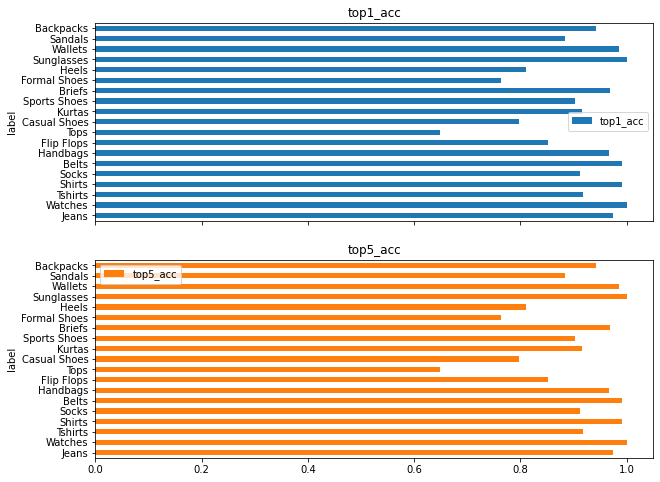

In [59]:
res_acc = plot_top_for_each_class(
    class_labels[train_df['class'].unique()],
    val_df, res_tr['best_model_path'],
    criterion
)

In [60]:
res_tst = test(dm, res_tr['best_model_path'], criterion)
results_balancing_methods['focal_loss'] = {'train': res_tr, 'test': res_tst[0], 'accuracies': res_acc}

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Testing: 100%|██████████| 54/54 [00:32<00:00,  2.12it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'top1_acc': tensor(0.6327, device='cuda:0'),
 'top5_acc': tensor(0.7006, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 54/54 [00:32<00:00,  1.66it/s]


#### Plot best model accuracies

In [72]:
#def plot_balancing_experiments_summary(results):
results = results_balancing_methods

In [88]:
#fig, axes = plt.subplots(1, 2, figsize=(12, 6))
top1_acc = []
top5_acc = []
labels = []
pos = []
for xx, exp_name in enumerate(results):
    top1_acc.append(results[exp_name]['test'][0]['top1_acc'])
    top5_acc.append(results[exp_name]['test'][0]['top5_acc'])
    labels.append(exp_name)

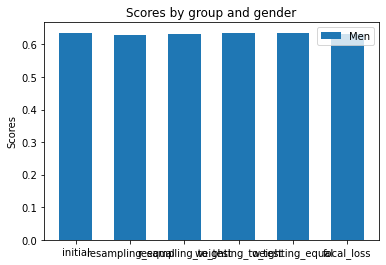

In [89]:
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.60  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, top1_acc, width, label='Men')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

TypeError: list indices must be integers or slices, not str

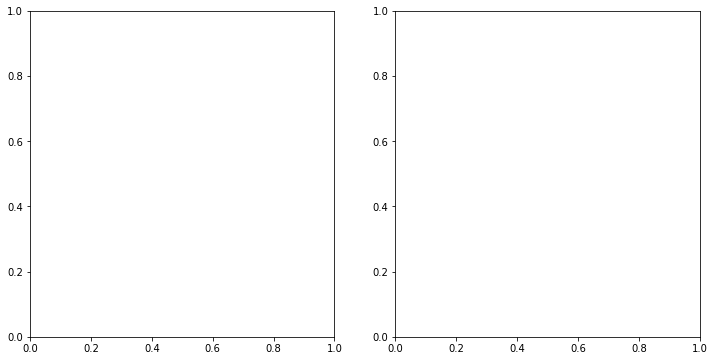

In [62]:
plot_balancing_experiments_summary(results_balancing_methods)

### All classes separately

In [46]:
idx = train_df['class'].value_counts().to_frame(name='counts').index
train_df.where(train_df['class']==idx[0]).dropna()

,image,class,class_label
2,data/myntradataset/images/53759.jpg,0.0,Tshirts
30,data/myntradataset/images/38630.jpg,0.0,Tshirts
39,data/myntradataset/images/2288.jpg,0.0,Tshirts
47,data/myntradataset/images/29584.jpg,0.0,Tshirts
75,data/myntradataset/images/24062.jpg,0.0,Tshirts
...,...,...,...
17984,data/myntradataset/images/37603.jpg,0.0,Tshirts
17988,data/myntradataset/images/24214.jpg,0.0,Tshirts
17992,data/myntradataset/images/38479.jpg,0.0,Tshirts
17993,data/myntradataset/images/1644.jpg,0.0,Tshirts


In [64]:
train_df

,image,class,class_label
0,data/myntradataset/images/39386.jpg,19,Jeans
1,data/myntradataset/images/59263.jpg,3,Watches
2,data/myntradataset/images/53759.jpg,0,Tshirts
3,data/myntradataset/images/30805.jpg,1,Shirts
4,data/myntradataset/images/26960.jpg,1,Shirts
...,...,...,...
17993,data/myntradataset/images/1644.jpg,0,Tshirts
17994,data/myntradataset/images/40563.jpg,3,Watches
17995,data/myntradataset/images/30614.jpg,0,Tshirts
17996,data/myntradataset/images/42234.jpg,6,Tops


## Other classes

In [21]:
a = pd.DataFrame()
a['top1'] = pd.Series({'a': 1, 'b': 2})
a['top5'] = pd.Series({'a': 3, 'b': 4})

In [22]:
a.to_dict()

{'top1': {'a': 1, 'b': 2}, 'top5': {'a': 3, 'b': 4}}